# To fix


# Plan
- Create an annotation file with VARIANT_TYPE, MULTIALLELIC and CDS using code from 20160722_mendelian_error_duplicate_concordance
- Function to create, for a given sample and GQ threshold, a list of variants (maybe using bcftools)
- Create confusion matrix from GATK and Thomas versions
- Function to create, for a sample, TP, FPhom, FPhet, FN, broken down by coding/variant_type/multi-allelic
- Function to create sum of these across 5 samples
- Function to turn this into a table
- 3 (FPhom, FPhet, FPall) GQ ROC (FDR vs sensitivity) for coding/variant_type/multi-allelic (12 lines) across all samples
- GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
- 12 GQ ROCs with line for each sample

- VQSLOD ROCs for coding/variant_type/multi-allelic (12 lines) across all samples
- 12 VQSLOD ROCs with line for each sample
- Does VQSLOD threshold 0 look sane?
- Create table for given GQ threshold
- Create table for no GQ or VQSLOD threshold
- Create table for GQ=99 and VQSLOD>=6


- Create VCF with genotypes filtered by GQ (i.e. missing if GQ < threshold)
- Calculate summary of full data set
- Calculate crosses variables
- Calculate FDR/sensitivity

In [1]:
%run _standard_imports.ipynb
%run _shared_setup.ipynb
%run _plotting_setup.ipynb

python 3.4.5 |Anaconda 2.2.0 (64-bit)| (default, Jul  2 2016, 17:47:47) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.11.1
scipy 0.18.0
pandas 0.19.0
numexpr 2.6.1
pysam 0.9.1.4
pysamstats 0.24.3
petl 1.1.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0.dev0
h5py 2.4.0
tables 3.1.1


In [2]:
release5_final_files_dir = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0'
# chrom_vcf_fn = "%s/SNP_INDEL_Pf3D7_14_v3.combined.filtered.vcf.gz" % (release5_final_files_dir)
wg_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.vcf.gz" % (release5_final_files_dir)
crosses_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.crosses.vcf.gz" % (release5_final_files_dir)
sites_only_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.sites.vcf.gz" % (release5_final_files_dir)
pacbio_vcf_fn = "/nfs/team112_internal/rp7/data/pf3k/pacbio_3/vcf/pf3k_pacbio_3.vcf.gz" # See 20161012_pf3k_pacbio_3_setup.ipynb

output_dir = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary"
!mkdir -p {output_dir}/vcf

fdr_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz" % output_dir
pacbio_fdr_vcf_fn = "%s/vcf/pf3k_pacbio_3.fdr.vcf.gz" % output_dir
release5_crosses_metadata_txt_fn = '../../meta/pf3k_release_5_crosses_metadata.txt'
release5_mixtures_metadata_txt_fn = '../../meta/pf3k_release_5_mixtures_metadata.txt'
gff_fn = "%s/Pfalciparum.noseq.gff3.gz" % output_dir
cds_gff_fn = "%s/Pfalciparum.noseq.gff3.cds.gz" % output_dir
core_bed_fn = '/nfs/users/nfs_r/rp7/temp_github_src/pf-crosses/meta/regions-20130115.Conserved.bed'

summary_table_fn = "%s/callset_summary.xlsx" % output_dir
# simplifed_counts_table_fn = "%s/simplified_variant_counts.xlsx" % output_dir

GENOME_FN = "/lustre/scratch109/malaria/pf3k_methods/resources/Pfalciparum.genome.fasta"

BCFTOOLS = '/nfs/team112_internal/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/bcftools/bcftools'
GATK = '/software/jre1.7.0_25/bin/java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar'

In [3]:
wg_vcf_fn

'/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_WG.combined.filtered.vcf.gz'

In [4]:
pacbio_vcf_reader = vcf.Reader(filename=pacbio_vcf_fn)
pacbio_samples = np.array(pacbio_vcf_reader.samples)
pacbio_samples

array(['Pf7G8', 'PfGB4', 'PfGN01', 'PfKE01', 'PfKH02'], 
      dtype='<U6')

In [5]:
fdr_samples = collections.OrderedDict()
fdr_samples['Pf7G8'] = '7G8' # This is 76bp crosses parent
fdr_samples['PfGB4'] = 'GB4' # This is 76bp crosses parent
fdr_samples['PfGN01'] = 'ERS740940' # This is 100bp version created from 250bp MiSeq data
fdr_samples['PfKE01'] = 'ERS740937' # This is 100bp version created from 250bp MiSeq data
# fdr_samples['PfKH02'] = 'PH0197-C' # This is 76bp originally sequenced sample. There is also 100bp version created from 250bp MiSeq data (ERS740936)
fdr_samples['PfKH02'] = 'ERS740936' # This is 100bp version created from 250bp MiSeq data, There is also 76bp originally sequenced sample (PH0197-C)

In [6]:
fdr_samples_text = ','.join(list(fdr_samples.values()))
fdr_samples_text

'7G8,GB4,ERS740940,ERS740937,ERS740936'

In [7]:
!wget ftp://ftp.sanger.ac.uk/pub/project/pathogens/gff3/2016-06/Pfalciparum.noseq.gff3.gz \
    -O {gff_fn}

--2016-10-22 12:07:20--  ftp://ftp.sanger.ac.uk/pub/project/pathogens/gff3/2016-06/Pfalciparum.noseq.gff3.gz
           => `/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/Pfalciparum.noseq.gff3.gz'
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/project/pathogens/gff3/2016-06 ... done.
==> SIZE Pfalciparum.noseq.gff3.gz ... 4852221
==> PASV ... done.    ==> RETR Pfalciparum.noseq.gff3.gz ... done.
Length: 4852221 (4.6M) (unauthoritative)

100%[======================================>] 4,852,221   --.-K/s   in 0.05s   

2016-10-22 12:07:20 (98.3 MB/s) - `/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/Pfalciparum.noseq.gff3.gz' saved [4852221]



In [8]:
!zgrep CDS {gff_fn} | sort -k1,1 -k4n,5n | cut -f 1,4,5 | sed 's/$/\t1/' | bgzip -c > {cds_gff_fn} && tabix -s1 -b2 -e3 {cds_gff_fn}

In [9]:
annotations_header_fn = "%s/vcf/annotations.hdr" % (output_dir)
fo=open(annotations_header_fn, 'w')
print('##INFO=<ID=CDS,Number=0,Type=Flag,Description="Is position coding">', file=fo)
print('##INFO=<ID=VARIANT_TYPE,Number=1,Type=String,Description="SNP or indel (IND)">', file=fo)
print('##INFO=<ID=MULTIALLELIC,Number=1,Type=String,Description="Is position biallelic (BI), biallelic plus spanning deletion (SD) or truly multiallelic (MU)">', file=fo)
fo.close()

In [8]:
def create_multiallelics_file(input_vcf_fn=sites_only_vcf_fn, multiallelics_fn=None):
    if multiallelics_fn is None:
        multiallelics_fn = "%s/vcf/SNP_INDEL_WG.sites.multiallelics.txt" % (output_dir)
    fo = open(multiallelics_fn, 'w')
    input_vcf_reader = vcf.Reader(filename=input_vcf_fn)
#     for record in input_vcf_reader.fetch('Pf3D7_01_v3', 29000, 29100):
    for record in input_vcf_reader:
        if len(record.ALT) == 1:
            multiallelic = 'BI'
        elif len(record.ALT) == 2 and (record.ALT[0] == '*' or record.ALT[1] == '*'):
            multiallelic = 'SD'
        else:
            multiallelic = 'MU'
#         print(multiallelic, record.ALT)
        print("%s\t%s\t%s\t%s\t%s" % (
                record.CHROM,
                record.POS,
                record.REF,
                ",".join([str(x) for x in record.ALT]),
                multiallelic), file=fo)
    fo.close()
    
    !bgzip {multiallelics_fn} && tabix -s1 -b2 -e2 {multiallelics_fn}.gz

In [85]:
temp = create_multiallelics_file()
temp

In [9]:
def create_annotation_file(input_vcf_fn=sites_only_vcf_fn, annotation_fn=None, BCFTOOLS=BCFTOOLS, rewrite=False):
    if annotation_fn is None:
        annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)
                                               
    intermediate_fns = collections.OrderedDict()
    for intermediate_file in ['snp', 'indel', 'multiallelics']:
        intermediate_fns[intermediate_file] = annotation_fn.replace('annotation', intermediate_file)

    if rewrite or not os.path.exists(intermediate_fns['snp']):
        !{BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\tSNP\n' --include 'TYPE="snp"' {input_vcf_fn} | \
        bgzip -c > {intermediate_fns['snp']} && tabix -s1 -b2 -e2 -f {intermediate_fns['snp']}

    if rewrite or not os.path.exists(intermediate_fns['indel']):
        !{BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\tINDEL\n' --include 'TYPE!="snp"' {input_vcf_fn} | \
        bgzip -c > {intermediate_fns['indel']} && tabix -s1 -b2 -e2 -f {intermediate_fns['indel']}

    if rewrite or not os.path.exists(intermediate_fns['multiallelics']):
        create_multiallelics_file(input_vcf_fn, "%s/vcf/pf3k_pacbio_3.multiallelics.txt" % (output_dir))
        
    if rewrite or not os.path.exists(annotation_fn):
        !{BCFTOOLS} annotate -a {cds_gff_fn} -c CHROM,FROM,TO,CDS -h {annotations_header_fn} {input_vcf_fn} | \
        {BCFTOOLS} annotate -a {intermediate_fns['snp']} -c CHROM,POS,REF,ALT,INFO/VARIANT_TYPE | \
        {BCFTOOLS} annotate -a {intermediate_fns['indel']} -c CHROM,POS,REF,ALT,INFO/VARIANT_TYPE | \
        {BCFTOOLS} annotate -a {intermediate_fns['multiallelics']} -c CHROM,POS,REF,ALT,INFO/MULTIALLELIC | \
        {BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\t%CDS\t%VARIANT_TYPE\t%MULTIALLELIC\n' | \
        bgzip -c > {annotation_fn}
        !tabix -s1 -b2 -e2 {annotation_fn}
      

In [87]:
create_annotation_file()

In [13]:
create_annotation_file(pacbio_vcf_fn, "%s/vcf/pf3k_pacbio_3.annotation.txt.gz" % (output_dir))

In [12]:
!zgrep SNP /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep INDEL /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep SNP SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep INDEL SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

2561890+1650575

2561890
1650575


4212465

In [90]:
# Here sanity checking that:
# a) Multi-allelic annotations are added 1-1
# b) Every position has a multi-allelic annotation

!zgrep MU /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep BI /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep SD /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

!zgrep MU /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l
!zgrep BI /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l
!zgrep SD /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l

# zgrep MU SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep BI SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep SD SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

# 1180582+2118683+913200
1267853+2116676+827936

1267853
2116676
827936
1267853
2116676
827936


4212465

In [91]:
# This command is slow (~1.5 hours)

annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)

# !{BCFTOOLS} view --regions Pf3D7_01_v3:29000-30000 --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
!{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,INFO/AF,INFO/VQSLOD,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {fdr_vcf_fn}

!{BCFTOOLS} index --tbi {fdr_vcf_fn}

Lines   total/split/realigned/skipped:	283133/253218/339064/0


In [90]:
pacbio_annotation_fn = "%s/vcf/pf3k_pacbio_3.annotation.txt.gz" % (output_dir)

!{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 {pacbio_vcf_fn} | \
{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {pacbio_annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {pacbio_fdr_vcf_fn}

!{BCFTOOLS} index --tbi {pacbio_fdr_vcf_fn}

Lines   total/split/realigned/skipped:	138566/50292/48401/0


In [34]:
def create_variants_npy(vcf_fn):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.variants(
        vcf_fn,
        fields=['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC',
                'AC', 'AN', 'FILTER'],
        dtypes={
            'REF':                      'a200',
            'ALT':                      'a200',
            'VARIANT_TYPE':             'a3',
            'CDS':                      bool,
            'MULTIALLELIC':             'a2',
        },
        arities={
            'ALT':   1,
            'AC':    1,
        },
        flatten_filter=True,
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )

def create_calldata_npy(vcf_fn, max_alleles=2):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.calldata_2d(
        vcf_fn,
        fields=['GT', 'AD', 'DP', 'GQ'],
        dtypes={
            'AD': 'u2',
        },
        arities={
            'AD': max_alleles,
        },
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )


In [94]:
create_variants_npy(fdr_vcf_fn)
create_calldata_npy(fdr_vcf_fn)


[vcfnp] 2016-10-21 11:11:23.898359 :: caching is enabled
[vcfnp] 2016-10-21 11:11:23.900831 :: no cache file found
[vcfnp] 2016-10-21 11:11:23.901873 :: building array
[vcfnp] 2016-10-21 11:11:26.745341 :: 100000 rows in 2.80s; batch in 2.80s (35757 rows/s)
[vcfnp] 2016-10-21 11:11:28.575096 :: 169464 rows in 4.63s (36629 rows/s)
[vcfnp] 2016-10-21 11:11:28.576519 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-10-21 11:11:28.723833 :: caching is enabled
[vcfnp] 2016-10-21 11:11:28.733069 :: no cache file found
[vcfnp] 2016-10-21 11:11:28.734260 :: building array
[vcfnp] 2016-10-21 11:11:33.669547 :: 100000 rows in 4.88s; batch in 4.88s (20491 rows/s)
[vcfnp] 2016-10-21 11:11:36.939550 :: 169464 rows in 8.15s (20792 rows/s)
[vcfnp] 2016-10-21 11:11:36.941084 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_s

In [95]:
create_variants_npy(pacbio_fdr_vcf_fn)
create_calldata_npy(pacbio_fdr_vcf_fn)


[vcfnp] 2016-10-21 11:11:41.646747 :: caching is enabled
[vcfnp] 2016-10-21 11:11:41.649909 :: no cache file found
[vcfnp] 2016-10-21 11:11:41.651157 :: building array
[vcfnp] 2016-10-21 11:11:44.028893 :: 100000 rows in 2.30s; batch in 2.30s (43455 rows/s)
[vcfnp] 2016-10-21 11:11:46.094792 :: 200000 rows in 4.37s; batch in 2.07s (48405 rows/s)
[vcfnp] 2016-10-21 11:11:46.327683 :: 210538 rows in 4.60s (45768 rows/s)
[vcfnp] 2016-10-21 11:11:46.329374 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/pf3k_pacbio_3.fdr.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-10-21 11:11:46.494958 :: caching is enabled
[vcfnp] 2016-10-21 11:11:46.497579 :: no cache file found
[vcfnp] 2016-10-21 11:11:46.499799 :: building array
[vcfnp] 2016-10-21 11:11:51.008049 :: 100000 rows in 4.49s; batch in 4.49s (22295 rows/s)
[vcfnp] 2016-10-21 11:11:55.522822 :: 200000 rows in 9.00s; batch in 4.51s (22149 rows/s)
[vcfnp] 2016-10-21 11:11:56.010554 :: 21

In [10]:
gatk_variants = np.load("%s.vcfnp_cache/variants.npy" % fdr_vcf_fn)
gatk_calldata = np.load("%s.vcfnp_cache/calldata_2d.npy" % fdr_vcf_fn)

pacbio_variants = np.load("%s.vcfnp_cache/variants.npy" % pacbio_fdr_vcf_fn)
pacbio_calldata = np.load("%s.vcfnp_cache/calldata_2d.npy" % pacbio_fdr_vcf_fn)


In [11]:
gatk_vcf_reader = vcf.Reader(filename=fdr_vcf_fn)
gatk_samples = np.array(gatk_vcf_reader.samples)
gatk_samples

array(['7G8', 'GB4', 'ERS740940', 'ERS740937', 'ERS740936'], 
      dtype='<U9')

In [12]:
gatk_samples == fdr_samples['Pf7G8']

array([ True, False, False, False, False], dtype=bool)

In [13]:
np.unique(gatk_calldata['GT'][:, gatk_samples == fdr_samples['Pf7G8']], return_counts=True)

(array([b'./.', b'0/0', b'0/1', b'1/0', b'1/1'], 
       dtype='|S3'), array([  8407, 108567,  11369,   1036,  40085]))

In [14]:
import pandas as pd

def set_status(df_calls):
    df_calls.assign(status='!!!NM')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'MIS'),
                 'status'] = '!!!NR'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS'),
                 'status'] = 'FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'1/1'),
                 'status'] = 'FPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'FPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'0/0'),
                 'status'] = '!TPHR'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FP'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] != b'MIS') & (df_calls['VARIANT_TYPE_x'] != b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'TPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'1/1'])),
                 'status'] = 'TPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/0'])),
                 'status'] = '!FPHR'
    return(df_calls)

def set_cds(df_calls):
    df_calls.assign(CDS=b'MIS')
    df_calls.loc[(df_calls['CDS_x'] == b'MIS'), 'CDS'] = df_calls.loc[(df_calls['CDS_x'] == b'MIS'), 'CDS_y']
    df_calls.loc[(df_calls['CDS_x'] != b'MIS'), 'CDS'] = df_calls.loc[(df_calls['CDS_x'] != b'MIS'), 'CDS_x']
    return(df_calls)

def set_variant_type(df_calls):
    df_calls.assign(VARIANT_TYPE=b'MIS')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS'), 'VARIANT_TYPE'] = df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS'), 'VARIANT_TYPE_y']
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS'), 'VARIANT_TYPE'] = df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS'), 'VARIANT_TYPE_x']
    return(df_calls)

def determine_fdr_pd(sample='Pf7G8', GQ_threshold=30):
    columns_of_interest = ['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
    ix_good_calls = np.logical_and(
        gatk_variants['FILTER_PASS'],
        gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold
    )
    ix_pacbio_calls = (pacbio_calldata['GT'][:, pacbio_samples == sample][:,0] == b'1/1')
    gatk_GT = gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0]
    df_gatk_calls = pd.DataFrame(gatk_variants[ix_good_calls]).loc[:, columns_of_interest]
    df_gatk_calls['GT'] = gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][ix_good_calls][:,0]
    df_pacbio_calls = pd.DataFrame(pacbio_variants[ix_pacbio_calls]).loc[:, columns_of_interest]
    df_calls = pd.merge(
        df_gatk_calls, df_pacbio_calls, how='outer', on=['CHROM', 'POS', 'REF', 'ALT']
    )
    df_calls['VARIANT_TYPE_x'].fillna(b'MIS', inplace=True)
    df_calls['VARIANT_TYPE_y'].fillna(b'MIS', inplace=True)
    df_calls['CDS_x'].fillna(b'MIS', inplace=True)
    df_calls['CDS_y'].fillna(b'MIS', inplace=True)
    df_calls['MULTIALLELIC_x'].fillna(b'MIS', inplace=True)
    df_calls = set_status(df_calls)
    df_calls = set_cds(df_calls)
    df_calls = set_variant_type(df_calls)
    
    gb = df_calls.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x', 'status']).size()
    return(gb, df_calls)
    


In [37]:
np.unique(gatk_variants['CHROM']

array([b'Pf3D7_01_v3', b'Pf3D7_01_v3', b'Pf3D7_01_v3', ..., b'Pf3D7_14_v3',
       b'Pf3D7_14_v3', b'Pf3D7_14_v3'], 
      dtype='|S12')

In [15]:
gb, df_calls = determine_fdr_pd()
gb

VARIANT_TYPE  CDS    MULTIALLELIC_x  status
b'IND'        False  b'BI'           !FPHR         4
                                     !TPHR       978
                                     FPhet        11
                                     FPhom         8
                                     TPhet         8
                                     TPhom       525
                     b'MIS'          FN        21287
                     b'MU'           !FPHR       111
                                     !TPHR     34767
                                     FPhet       799
                                     FPhom       281
                                     TPhet       709
                                     TPhom     15398
                     b'SD'           !FPHR        11
                                     !TPHR      2038
                                     FPhet        80
                                     FPhom        26
                                     TPhet        52
  

In [17]:
gb.groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()

VARIANT_TYPE  CDS    status
b'IND'        False  !FPHR       126
                     !TPHR     37783
                     FN        21287
                     FPhet       890
                     FPhom       315
                     TPhet       769
                     TPhom     16650
              True   !FPHR       165
                     !TPHR      9947
                     FN         2378
                     FPhet       154
                     FPhom       195
                     TPhet        77
                     TPhom      3982
b'SNP'        False  !FPHR         5
                     !TPHR      7310
                     FN         2794
                     FPhet       132
                     FPhom        70
                     TPhet        33
                     TPhom      4335
              True   !FPHR        18
                     !TPHR     10229
                     FN         2221
                     FPhet        61
                     FPhom        62
          

In [18]:
gb.groupby(level=['status']).sum()

status
!FPHR      314
!TPHR    65269
FN       28680
FPhet     1237
FPhom      642
TPhet      903
TPhom    30915
dtype: int64

In [19]:
GQ_dict = collections.OrderedDict()
for GQ_threshold in np.arange(0, 100):
    print(GQ_threshold, end=" ")
    GQ_dict[GQ_threshold] = collections.OrderedDict()
    for sample in pacbio_samples:
        GQ_dict[GQ_threshold][sample], _ = determine_fdr_pd(sample, GQ_threshold)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [20]:
GQ_dict[30]['Pf7G8']

VARIANT_TYPE  CDS    MULTIALLELIC_x  status
b'IND'        False  b'BI'           !FPHR         4
                                     !TPHR       978
                                     FPhet        11
                                     FPhom         8
                                     TPhet         8
                                     TPhom       525
                     b'MIS'          FN        21287
                     b'MU'           !FPHR       111
                                     !TPHR     34767
                                     FPhet       799
                                     FPhom       281
                                     TPhet       709
                                     TPhom     15398
                     b'SD'           !FPHR        11
                                     !TPHR      2038
                                     FPhet        80
                                     FPhom        26
                                     TPhet        52
  

In [21]:
df_colours = pd.DataFrame(
    [
        [b'SNP', True, b'all', '#a50f15'], # ColorBrewer 5-class Reds
        [b'SNP', True, b'het', '#de2d26'],
        [b'SNP', True, b'hom', '#fb6a4a'],
        [b'IND', True, b'all', '#08519c'], # ColorBrewer 5-class Blues
        [b'IND', True, b'het', '#3182bd'],
        [b'IND', True, b'hom', '#6baed6'],
        [b'SNP', False, b'all', '#a63603'], # ColorBrewer 5-class Oranges
        [b'SNP', False, b'het', '#e6550d'],
        [b'SNP', False, b'hom', '#fd8d3c'],
        [b'IND', False, b'all', '#006d2c'], # ColorBrewer 5-class Greens
        [b'IND', False, b'het', '#31a354'],
        [b'IND', False, b'hom', '#74c476'],
    ],
    columns = ['VARIANT_TYPE', 'CDS_GATK', 'FDR', 'colour']
)
df_colours

,VARIANT_TYPE,CDS_GATK,FDR,colour
0,b'SNP',True,b'all',#a50f15
1,b'SNP',True,b'het',#de2d26
2,b'SNP',True,b'hom',#fb6a4a
3,b'IND',True,b'all',#08519c
4,b'IND',True,b'het',#3182bd
5,b'IND',True,b'hom',#6baed6
6,b'SNP',False,b'all',#a63603
7,b'SNP',False,b'het',#e6550d
8,b'SNP',False,b'hom',#fd8d3c
9,b'IND',False,b'all',#006d2c


In [22]:
df_colours.set_index(['VARIANT_TYPE', 'CDS_GATK', 'FDR'], inplace=True)
df_colours

colour
VARIANT_TYPE CDS_GATK FDR            
b'SNP'       True     b'all'  #a50f15
                      b'het'  #de2d26
                      b'hom'  #fb6a4a
b'IND'       True     b'all'  #08519c
                      b'het'  #3182bd
                      b'hom'  #6baed6
b'SNP'       False    b'all'  #a63603
                      b'het'  #e6550d
                      b'hom'  #fd8d3c
b'IND'       False    b'all'  #006d2c
                      b'het'  #31a354
                      b'hom'  #74c476

In [23]:
df_colours['colour'][b'SNP'][False][b'het']

'#e6550d'

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


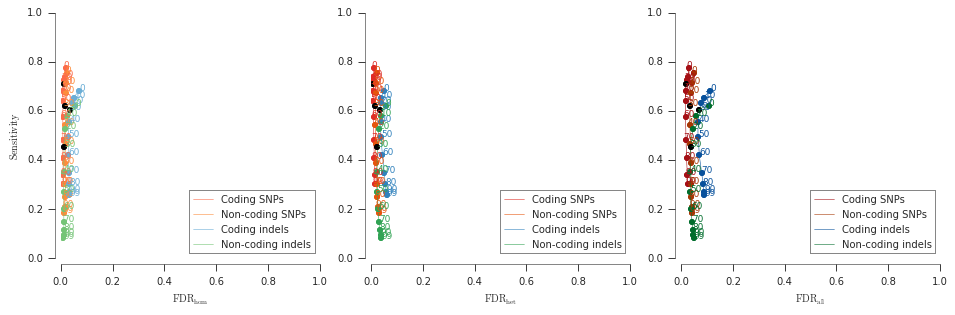

In [35]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for variant_type in [b'SNP', b'IND']:
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for coding in [True, False]:
        FDR[variant_type][coding] = collections.OrderedDict()
        FDR[variant_type][coding]['FPhom'] = np.zeros(100, dtype=float)
        FDR[variant_type][coding]['FPhet'] = np.zeros(100, dtype=float)
        FDR[variant_type][coding]['FPall'] = np.zeros(100, dtype=float)
        sensitivity[variant_type][coding] = np.zeros(100, dtype=float)
        for GQ_threshold in np.arange(0, 100):
            TP = 0
            FPhom = 0
            FPhet = 0
            FPall = 0
            FN = 0
            for sample in pacbio_samples:
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = FPhom + status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = FPhet + status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = TP + status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = FN + status_sum[variant_type][coding]['FN']
            FDR[variant_type][coding]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
            FDR[variant_type][coding]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
            FDR[variant_type][coding]['FPall'][GQ_threshold] = FPall/(TP+FPall)
            sensitivity[variant_type][coding][GQ_threshold] = TP/(TP+FN)
        colour = df_colours['colour'][variant_type][coding][b'hom']
        if variant_type == b'SNP':
            text_offset = -0.007
        else:
            text_offset = 0.002
        if coding == True and variant_type == b'SNP':
            label = "Coding SNPs" 
        if coding == False and variant_type == b'SNP':
            label = "Non-coding SNPs" 
        if coding == True and variant_type == b'IND':
            label = "Coding indels" 
        if coding == False and variant_type == b'IND':
            label = "Non-coding indels" 
        ax1.plot(FDR[variant_type][coding]['FPhom'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax1.plot(FDR[variant_type][coding]['FPhom'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax1.plot(FDR[variant_type][coding]['FPhom'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax1.text(FDR[variant_type][coding]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        colour = df_colours['colour'][variant_type][coding][b'het']
        ax2.plot(FDR[variant_type][coding]['FPhet'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax2.plot(FDR[variant_type][coding]['FPhet'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax2.plot(FDR[variant_type][coding]['FPhet'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax2.text(FDR[variant_type][coding]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        colour = df_colours['colour'][variant_type][coding][b'all']
        ax3.plot(FDR[variant_type][coding]['FPall'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax3.plot(FDR[variant_type][coding]['FPall'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax3.plot(FDR[variant_type][coding]['FPall'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax3.text(FDR[variant_type][coding]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        sns.despine(ax=ax1, offset=5)
        sns.despine(ax=ax2, offset=5)
        sns.despine(ax=ax3, offset=5)
        ax1.set_xlim(0, 1)
        ax2.set_xlim(0, 1)
        ax3.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax2.set_ylim(0, 1)
        ax3.set_ylim(0, 1)
        ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
        ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
        ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
        ax1.set_ylabel(r'$\mathrm{Sensitivity}$')
        ax1.legend(loc='lower right')
        ax2.legend(loc='lower right')
        ax3.legend(loc='lower right')

fig.tight_layout()


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


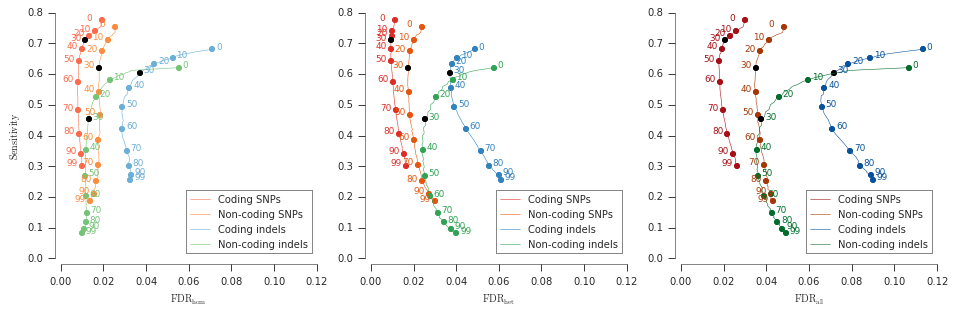

In [24]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for variant_type in [b'SNP', b'IND']:
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for coding in [True, False]:
        FDR[variant_type][coding] = collections.OrderedDict()
        FDR[variant_type][coding]['FPhom'] = np.zeros(100, dtype=float)
        FDR[variant_type][coding]['FPhet'] = np.zeros(100, dtype=float)
        FDR[variant_type][coding]['FPall'] = np.zeros(100, dtype=float)
        sensitivity[variant_type][coding] = np.zeros(100, dtype=float)
        for GQ_threshold in np.arange(0, 100):
            TP = 0
            FPhom = 0
            FPhet = 0
            FPall = 0
            FN = 0
            for sample in pacbio_samples:
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = FPhom + status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = FPhet + status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = TP + status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = FN + status_sum[variant_type][coding]['FN']
            FDR[variant_type][coding]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
            FDR[variant_type][coding]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
            FDR[variant_type][coding]['FPall'][GQ_threshold] = FPall/(TP+FPall)
            sensitivity[variant_type][coding][GQ_threshold] = TP/(TP+FN)
        colour = df_colours['colour'][variant_type][coding][b'hom']
        if variant_type == b'SNP':
            text_offset = -0.007
        else:
            text_offset = 0.002
        if coding == True and variant_type == b'SNP':
            label = "Coding SNPs" 
        if coding == False and variant_type == b'SNP':
            label = "Non-coding SNPs" 
        if coding == True and variant_type == b'IND':
            label = "Coding indels" 
        if coding == False and variant_type == b'IND':
            label = "Non-coding indels" 
        ax1.plot(FDR[variant_type][coding]['FPhom'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax1.plot(FDR[variant_type][coding]['FPhom'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax1.plot(FDR[variant_type][coding]['FPhom'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax1.text(FDR[variant_type][coding]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        colour = df_colours['colour'][variant_type][coding][b'het']
        ax2.plot(FDR[variant_type][coding]['FPhet'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax2.plot(FDR[variant_type][coding]['FPhet'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax2.plot(FDR[variant_type][coding]['FPhet'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax2.text(FDR[variant_type][coding]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        colour = df_colours['colour'][variant_type][coding][b'all']
        ax3.plot(FDR[variant_type][coding]['FPall'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax3.plot(FDR[variant_type][coding]['FPall'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax3.plot(FDR[variant_type][coding]['FPall'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax3.text(FDR[variant_type][coding]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        sns.despine(ax=ax1, offset=5)
        sns.despine(ax=ax2, offset=5)
        sns.despine(ax=ax3, offset=5)
        ax1.set_xlim(0, 0.12)
        ax2.set_xlim(0, 0.12)
        ax3.set_xlim(0, 0.12)
        ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
        ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
        ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
        ax1.set_ylabel(r'$\mathrm{Sensitivity}$')
        ax1.legend(loc='lower right')
        ax2.legend(loc='lower right')
        ax3.legend(loc='lower right')

fig.tight_layout()


In [25]:
sample_colours = { # ColorBrewer 5-class Set 1
    'Pf7G8': '#e41a1c',
    'PfGB4': '#377eb8',
    'PfGN01': '#4daf4a',
    'PfKE01': '#984ea3',
    'PfKH02': '#ff7f00',
}
sample_colours['PfKE01']

'#984ea3'

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


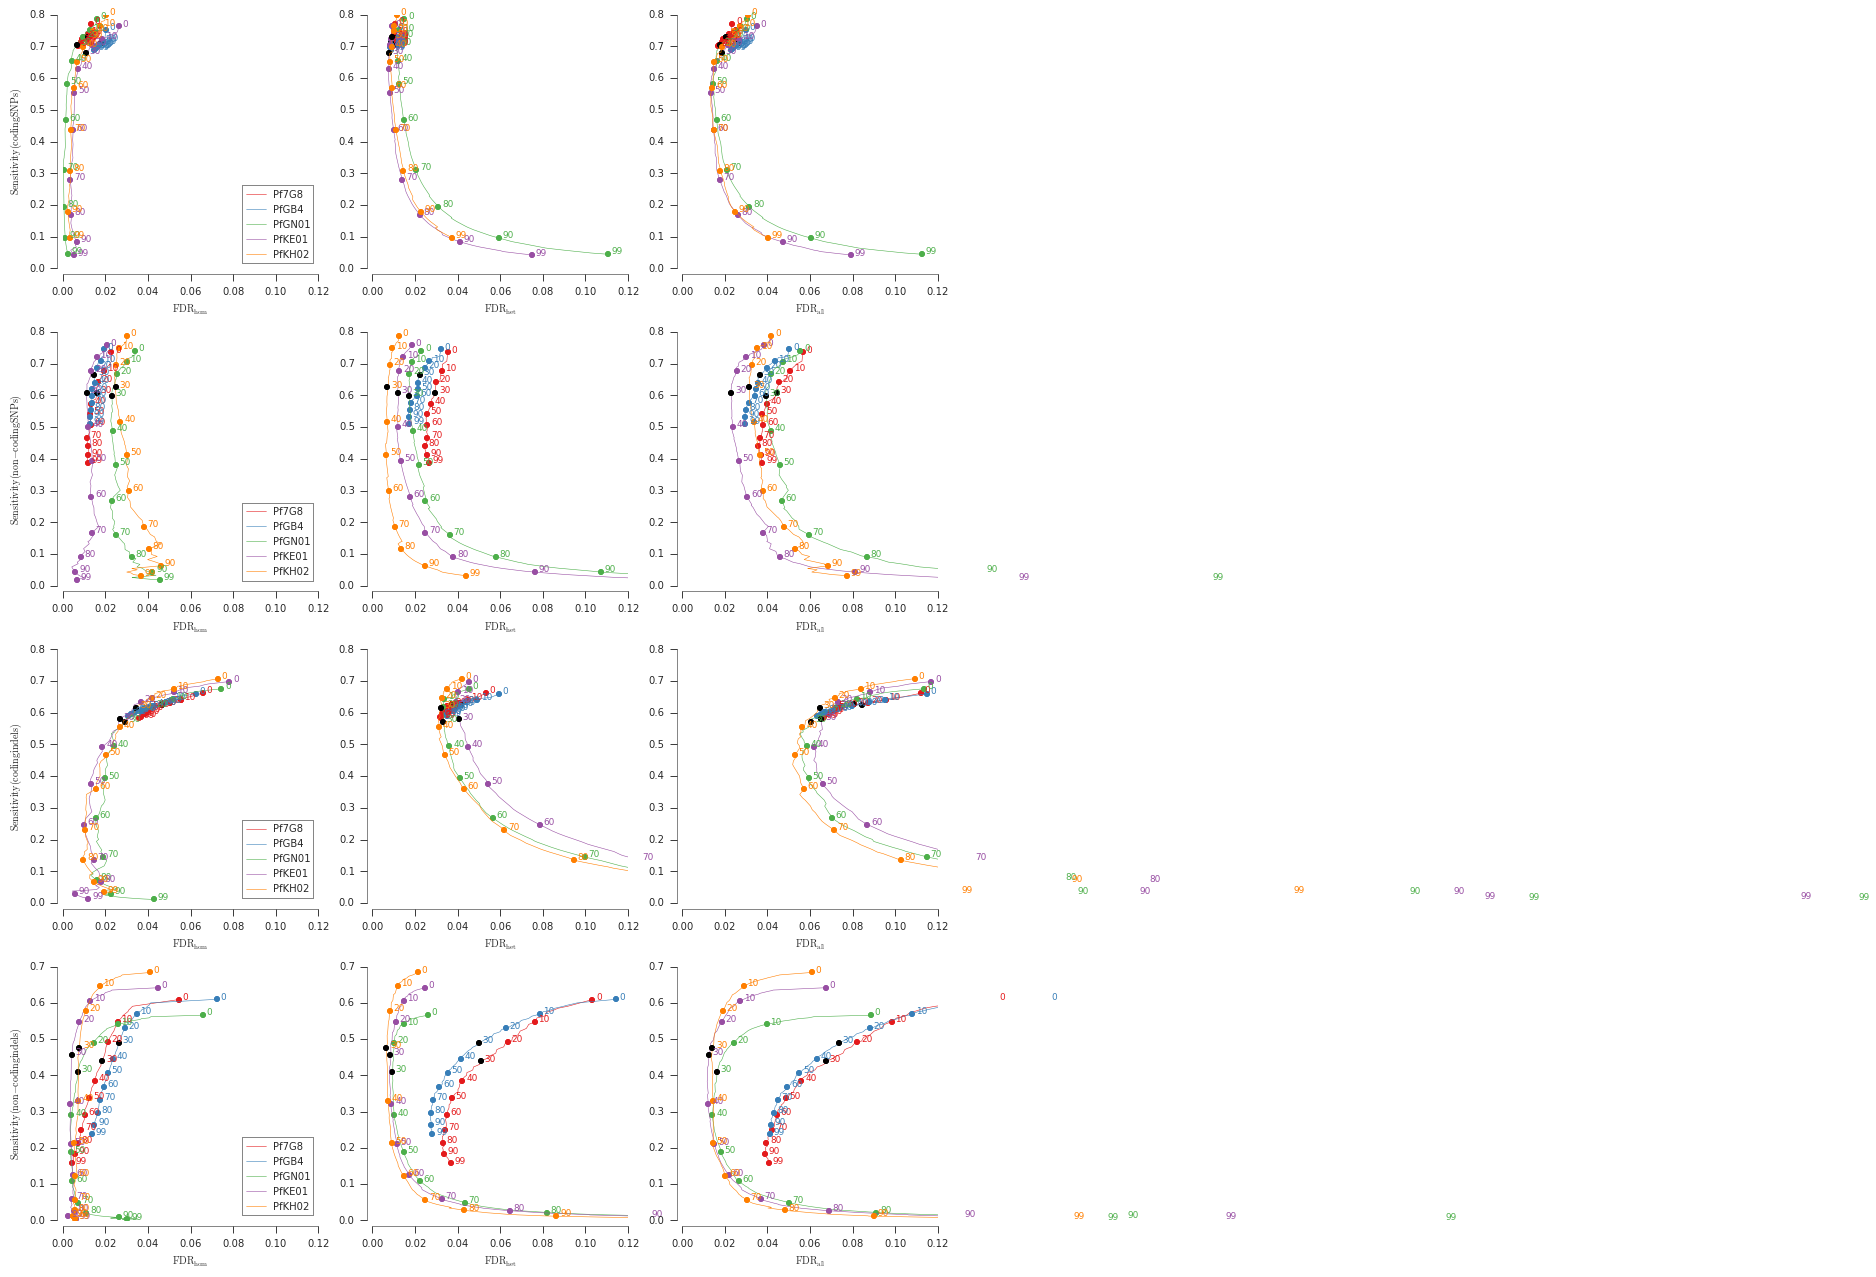

In [26]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 16))
gs = mpl.gridspec.GridSpec(4, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for i, variant_type in enumerate([b'SNP', b'IND']):
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for j, coding in enumerate([True, False]):
        FDR[variant_type][coding] = collections.OrderedDict()
        sensitivity[variant_type][coding] = collections.OrderedDict()
        row_num = (i*2) + j
        ax1 = fig.add_subplot(gs[row_num, 0])
        ax2 = fig.add_subplot(gs[row_num, 1])
        ax3 = fig.add_subplot(gs[row_num, 2])
        for sample in pacbio_samples:
            FDR[variant_type][coding][sample] = collections.OrderedDict()
            FDR[variant_type][coding][sample]['FPhom'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPhet'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPall'] = np.zeros(100, dtype=float)
            sensitivity[variant_type][coding][sample] = np.zeros(100, dtype=float)
            for GQ_threshold in np.arange(0, 100):
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = status_sum[variant_type][coding]['FN']
                FDR[variant_type][coding][sample]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
                FDR[variant_type][coding][sample]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
                FDR[variant_type][coding][sample]['FPall'][GQ_threshold] = FPall/(TP+FPall)
                sensitivity[variant_type][coding][sample][GQ_threshold] = TP/(TP+FN)
            colour = sample_colours[sample]
            if coding == True and variant_type == b'SNP':
                label = "Sensitivity (coding SNPs)" 
            if coding == False and variant_type == b'SNP':
                label = "Sensitivity (non-coding SNPs)" 
            if coding == True and variant_type == b'IND':
                label = "Sensitivity (coding indels)" 
            if coding == False and variant_type == b'IND':
                label = "Sensitivity (non-coding indels)" 
            ax1.plot(FDR[variant_type][coding][sample]['FPhom'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax1.text(FDR[variant_type][coding][sample]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][b'het']
            ax2.plot(FDR[variant_type][coding][sample]['FPhet'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax2.text(FDR[variant_type][coding][sample]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][[sample]b'all']
            ax3.plot(FDR[variant_type][coding][sample]['FPall'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax3.text(FDR[variant_type][coding][sample]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
            sns.despine(ax=ax1, offset=5)
            sns.despine(ax=ax2, offset=5)
            sns.despine(ax=ax3, offset=5)
            ax1.set_xlim(0, 0.12)
            ax2.set_xlim(0, 0.12)
            ax3.set_xlim(0, 0.12)
            ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax1.set_ylabel(r'$\mathrm{%s}$' % label)
            ax1.legend(loc='lower right')

fig.tight_layout()


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


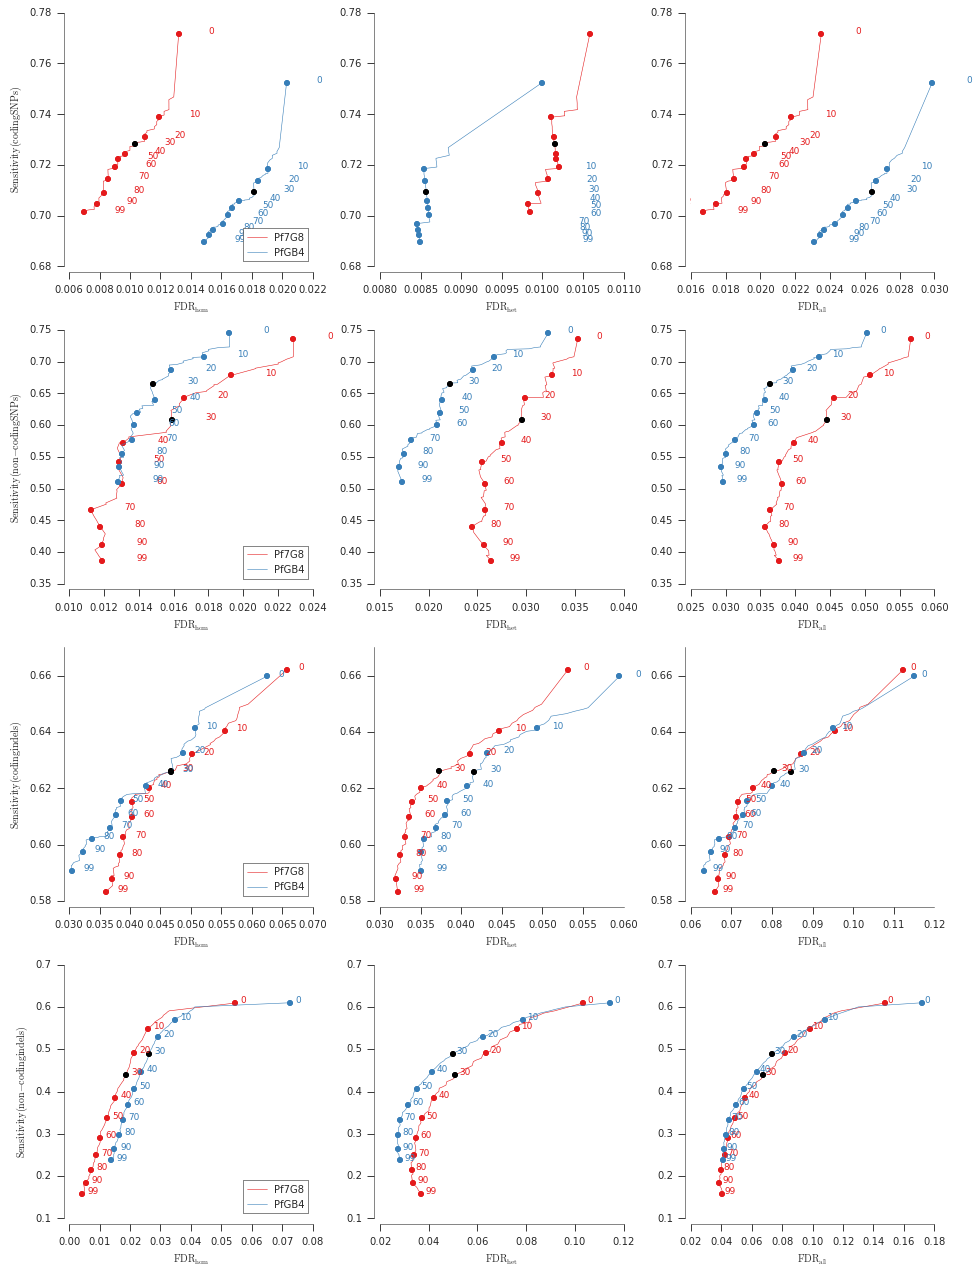

In [32]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 16))
gs = mpl.gridspec.GridSpec(4, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for i, variant_type in enumerate([b'SNP', b'IND']):
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for j, coding in enumerate([True, False]):
        FDR[variant_type][coding] = collections.OrderedDict()
        sensitivity[variant_type][coding] = collections.OrderedDict()
        row_num = (i*2) + j
        ax1 = fig.add_subplot(gs[row_num, 0])
        ax2 = fig.add_subplot(gs[row_num, 1])
        ax3 = fig.add_subplot(gs[row_num, 2])
        for sample in ['Pf7G8', 'PfGB4']:
            FDR[variant_type][coding][sample] = collections.OrderedDict()
            FDR[variant_type][coding][sample]['FPhom'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPhet'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPall'] = np.zeros(100, dtype=float)
            sensitivity[variant_type][coding][sample] = np.zeros(100, dtype=float)
            for GQ_threshold in np.arange(0, 100):
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = status_sum[variant_type][coding]['FN']
                FDR[variant_type][coding][sample]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
                FDR[variant_type][coding][sample]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
                FDR[variant_type][coding][sample]['FPall'][GQ_threshold] = FPall/(TP+FPall)
                sensitivity[variant_type][coding][sample][GQ_threshold] = TP/(TP+FN)
            colour = sample_colours[sample]
            if coding == True and variant_type == b'SNP':
                label = "Sensitivity (coding SNPs)" 
            if coding == False and variant_type == b'SNP':
                label = "Sensitivity (non-coding SNPs)" 
            if coding == True and variant_type == b'IND':
                label = "Sensitivity (coding indels)" 
            if coding == False and variant_type == b'IND':
                label = "Sensitivity (non-coding indels)" 
            ax1.plot(FDR[variant_type][coding][sample]['FPhom'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax1.text(FDR[variant_type][coding][sample]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][b'het']
            ax2.plot(FDR[variant_type][coding][sample]['FPhet'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax2.text(FDR[variant_type][coding][sample]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][[sample]b'all']
            ax3.plot(FDR[variant_type][coding][sample]['FPall'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax3.text(FDR[variant_type][coding][sample]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
            sns.despine(ax=ax1, offset=5)
            sns.despine(ax=ax2, offset=5)
            sns.despine(ax=ax3, offset=5)
#             ax1.set_xlim(0, 0.12)
#             ax2.set_xlim(0, 0.12)
#             ax3.set_xlim(0, 0.12)
#             ax1.set_ylim(0, 0.8)
#             ax2.set_ylim(0, 0.8)
#             ax3.set_ylim(0, 0.8)
            ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax1.set_ylabel(r'$\mathrm{%s}$' % label)
            ax1.legend(loc='lower right')

fig.tight_layout()


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


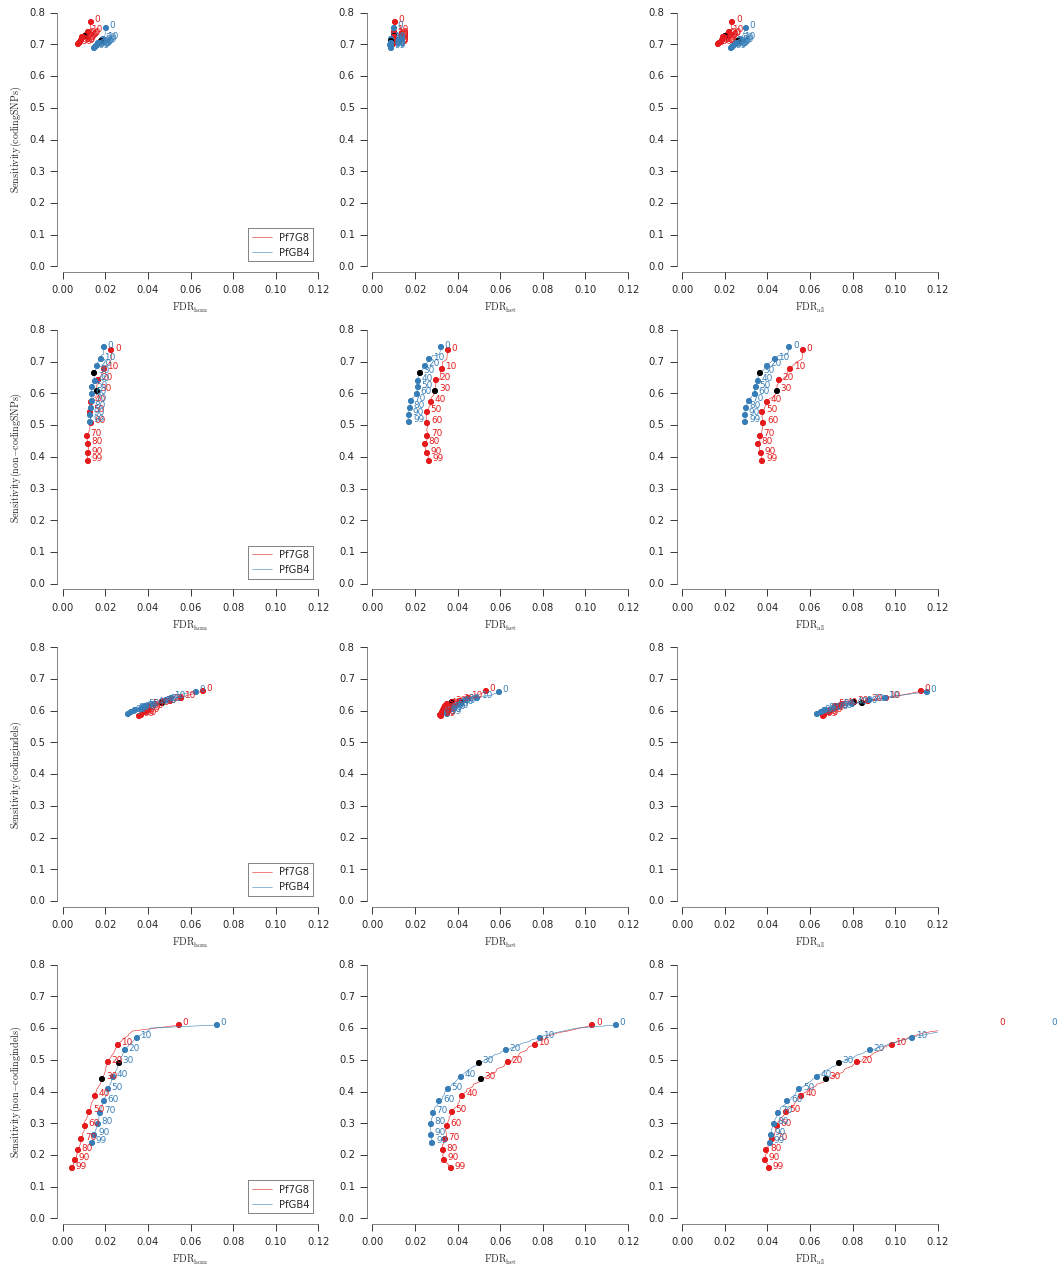

In [33]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 16))
gs = mpl.gridspec.GridSpec(4, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for i, variant_type in enumerate([b'SNP', b'IND']):
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for j, coding in enumerate([True, False]):
        FDR[variant_type][coding] = collections.OrderedDict()
        sensitivity[variant_type][coding] = collections.OrderedDict()
        row_num = (i*2) + j
        ax1 = fig.add_subplot(gs[row_num, 0])
        ax2 = fig.add_subplot(gs[row_num, 1])
        ax3 = fig.add_subplot(gs[row_num, 2])
        for sample in ['Pf7G8', 'PfGB4']:
            FDR[variant_type][coding][sample] = collections.OrderedDict()
            FDR[variant_type][coding][sample]['FPhom'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPhet'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPall'] = np.zeros(100, dtype=float)
            sensitivity[variant_type][coding][sample] = np.zeros(100, dtype=float)
            for GQ_threshold in np.arange(0, 100):
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = status_sum[variant_type][coding]['FN']
                FDR[variant_type][coding][sample]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
                FDR[variant_type][coding][sample]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
                FDR[variant_type][coding][sample]['FPall'][GQ_threshold] = FPall/(TP+FPall)
                sensitivity[variant_type][coding][sample][GQ_threshold] = TP/(TP+FN)
            colour = sample_colours[sample]
            if coding == True and variant_type == b'SNP':
                label = "Sensitivity (coding SNPs)" 
            if coding == False and variant_type == b'SNP':
                label = "Sensitivity (non-coding SNPs)" 
            if coding == True and variant_type == b'IND':
                label = "Sensitivity (coding indels)" 
            if coding == False and variant_type == b'IND':
                label = "Sensitivity (non-coding indels)" 
            ax1.plot(FDR[variant_type][coding][sample]['FPhom'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax1.text(FDR[variant_type][coding][sample]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][b'het']
            ax2.plot(FDR[variant_type][coding][sample]['FPhet'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax2.text(FDR[variant_type][coding][sample]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][[sample]b'all']
            ax3.plot(FDR[variant_type][coding][sample]['FPall'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax3.text(FDR[variant_type][coding][sample]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
            sns.despine(ax=ax1, offset=5)
            sns.despine(ax=ax2, offset=5)
            sns.despine(ax=ax3, offset=5)
            ax1.set_xlim(0, 0.12)
            ax2.set_xlim(0, 0.12)
            ax3.set_xlim(0, 0.12)
            ax1.set_ylim(0, 0.8)
            ax2.set_ylim(0, 0.8)
            ax3.set_ylim(0, 0.8)
            ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax1.set_ylabel(r'$\mathrm{%s}$' % label)
            ax1.legend(loc='lower right')

fig.tight_layout()


# Decision on GQ threshold
After thinking about the results of the above plots, I decided against using a GQ threshold becuase:
1. There is clearly a threshold, above which the genotype quality drops, and this threshold is dependent on the depth of coverage (field sample used here have ~30x coverage whereas crosses parents have ~100x coverage)
1. Because of the above we clearly need to use "typical" samples, and typical coverage is ~100x (though there is great variance in sample coverage). For the crosses parents (which we think are typical) there is no obvious cut-off - the choice is very much dependent on the balance between sensitivity and specificity (i.e. on the relative costs of FPs and FNs)
1. If FP and FN are treated as equally bad, the best threshold to use is 0
1. It might be better to use a measure more like QD (e.g. GQ/DP), but this really requires more in-depth exploration
1. Good thresholds might look very different if we filter variants differently in the future, e.g. by incorporating a hyperhet filter. Therefore, we probably want to explore both variant-level and genotype-level filters at the same time.
1. Although the crosses parents have typical coverage, they don't have typical read length (76bp), and therefore a proper analysis of GQ thresholds should perhaps wait until we have incorporated the samples from study 1153
1. We decided to stick to GATK recommendations, and no recommendations are given for GQ thresholds


In [27]:
def confusion_tr_style(row):
    style = 'background-color: %s' % ('#4f4' if row.status == 'TP' 
                                      else '#f44' if row.status == 'FP'
                                      else '#44f' if row.status == 'FN'
                                      else 'white')
    return style


In [28]:
df_calls.display(100, tr_style=confusion_tr_style)

AttributeError: 'DataFrame' object has no attribute 'display'